# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
!ls -al /input

total 8308
drwxr-xr-x   4 root root    6144 Apr 29 00:27 .
drwxr-xr-x 138 root root    4096 Aug 16 15:51 ..
drwxr-xr-x   2 root root 6137856 Apr 28 19:01 img_align_celeba
drwxr-xr-x   2 root root 2365440 Apr 28 18:57 mnist


In [2]:
data_dir = '/input'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

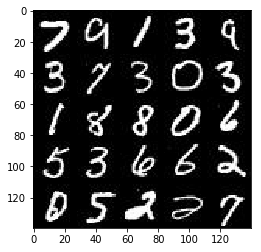

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

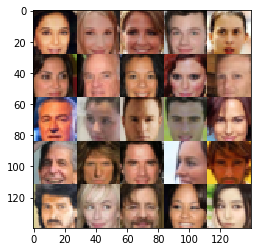

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    
    real_inputs = tf.placeholder(
        tf.float32, 
        (None, image_height, image_width, image_channels),
        name='real_inputs'
    )
    z_inputs = tf.placeholder(tf.float32, (None, z_dim), name='z_inputs')
    lrate = tf.placeholder(tf.float32, name='lrate')
    return real_inputs, z_inputs, lrate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [33]:
def discriminator(images, reuse=False, alpha=0.2, kernel=5, filters=32):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # Input layer is 28x28x3
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(images, filters, kernel, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x32
        
        x2 = tf.layers.conv2d(x1, filters*2, kernel, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x64
        
        x3 = tf.layers.conv2d(x2, filters*2, kernel, strides=1, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        
        flat = tf.reshape(relu3, (-1, 7*7*filters*2))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [41]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2, kernel=5):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=not is_train):
        x1 = tf.layers.dense(z, 7*7*512)
        
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x512
        
        x2 = tf.layers.conv2d_transpose(x1, 128, kernel, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x256
        
        x3 = tf.layers.conv2d_transpose(x2, 64, kernel, strides=1, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 14x14x128
        
        logits = tf.layers.conv2d_transpose(
            x3, out_channel_dim, kernel, strides=2, padding='same')
        # 28x28x3
        
        out = tf.tanh(logits)
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)






Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [42]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    gen_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(gen_model, reuse=True)
    
    ones_like_real = tf.ones_like(d_model_real)
    one_sided_smooth_labels = tf.multiply(
        ones_like_real,
        tf.random_uniform((1,), minval=0.8, maxval=1.2)
    )

    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_real, labels=one_sided_smooth_labels
        )
    )
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)
        )
    )
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_fake, labels=tf.ones_like(d_model_fake)
        )
    )
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [43]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [44]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [45]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    steps=0
    
    # TODO: Build Model
    image_channels = 3 if data_image_mode == 'RGB' else 1
    image_height, image_width = data_shape[1], data_shape[2]
    real_inputs, z_inputs, lrate = model_inputs(
        image_width, image_height, image_channels, z_dim)
        
    d_loss, g_loss = model_loss(real_inputs, z_inputs, image_channels)
    
    d_opt, g_opt = model_opt(d_loss, g_loss, lrate, beta1)
        
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                
                steps += 1
                batch_images = 2 * batch_images
                
                batch_z = np.random.uniform(-1 ,1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={
                    real_inputs: batch_images,
                    z_inputs: batch_z,
                    lrate: learning_rate
                })
                
                # Double the number of trains to generator
                _ = sess.run(g_opt, feed_dict={
                    z_inputs: batch_z,
                    real_inputs: batch_images,
                    lrate: learning_rate
                })
                
                
                if steps % 10 == 0:
                    # At the end of every 10 epochs, get the losses and print them out
                    train_loss_d = d_loss.eval({z_inputs: batch_z, real_inputs: batch_images})
                    train_loss_g = g_loss.eval({z_inputs: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g),
                          "Sum Loss: {:.4f}".format(train_loss_g+train_loss_d))
                
                if steps % 100 == 0:
                    show_generator_output(
                        sess,
                        25,
                        z_inputs,
                        image_channels,
                        data_image_mode
                    )
                  
        show_generator_output(sess, 25, z_inputs, image_channels, data_image_mode)

                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 3.2521... Generator Loss: 0.0616 Sum Loss: 3.3137
Epoch 1/2... Discriminator Loss: 3.6962... Generator Loss: 0.0447 Sum Loss: 3.7409
Epoch 1/2... Discriminator Loss: 2.0749... Generator Loss: 0.1996 Sum Loss: 2.2745
Epoch 1/2... Discriminator Loss: 2.6605... Generator Loss: 0.1267 Sum Loss: 2.7872
Epoch 1/2... Discriminator Loss: 2.3701... Generator Loss: 0.3087 Sum Loss: 2.6788
Epoch 1/2... Discriminator Loss: 2.4862... Generator Loss: 0.2363 Sum Loss: 2.7225
Epoch 1/2... Discriminator Loss: 2.0737... Generator Loss: 0.3920 Sum Loss: 2.4657
Epoch 1/2... Discriminator Loss: 2.1324... Generator Loss: 0.5247 Sum Loss: 2.6571
Epoch 1/2... Discriminator Loss: 1.9378... Generator Loss: 0.5742 Sum Loss: 2.5119
Epoch 1/2... Discriminator Loss: 1.7664... Generator Loss: 0.4327 Sum Loss: 2.1991


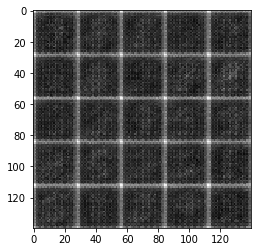

Epoch 1/2... Discriminator Loss: 1.6351... Generator Loss: 0.6324 Sum Loss: 2.2675
Epoch 1/2... Discriminator Loss: 1.5853... Generator Loss: 0.6570 Sum Loss: 2.2423
Epoch 1/2... Discriminator Loss: 1.5580... Generator Loss: 0.5716 Sum Loss: 2.1296
Epoch 1/2... Discriminator Loss: 1.5007... Generator Loss: 0.6573 Sum Loss: 2.1580
Epoch 1/2... Discriminator Loss: 1.5475... Generator Loss: 0.5982 Sum Loss: 2.1457
Epoch 1/2... Discriminator Loss: 1.5449... Generator Loss: 0.4361 Sum Loss: 1.9810
Epoch 1/2... Discriminator Loss: 1.5259... Generator Loss: 0.6898 Sum Loss: 2.2157
Epoch 1/2... Discriminator Loss: 1.3912... Generator Loss: 0.6421 Sum Loss: 2.0333
Epoch 1/2... Discriminator Loss: 1.5216... Generator Loss: 0.4152 Sum Loss: 1.9368
Epoch 1/2... Discriminator Loss: 1.4083... Generator Loss: 0.6790 Sum Loss: 2.0873


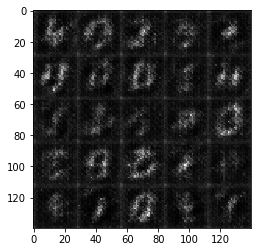

Epoch 1/2... Discriminator Loss: 1.5018... Generator Loss: 0.4176 Sum Loss: 1.9193
Epoch 1/2... Discriminator Loss: 1.4115... Generator Loss: 0.7886 Sum Loss: 2.2001
Epoch 1/2... Discriminator Loss: 1.4269... Generator Loss: 0.6839 Sum Loss: 2.1108
Epoch 1/2... Discriminator Loss: 1.5526... Generator Loss: 0.3847 Sum Loss: 1.9373
Epoch 1/2... Discriminator Loss: 1.4896... Generator Loss: 0.5497 Sum Loss: 2.0393
Epoch 1/2... Discriminator Loss: 1.6618... Generator Loss: 1.1084 Sum Loss: 2.7702
Epoch 1/2... Discriminator Loss: 1.3793... Generator Loss: 0.8634 Sum Loss: 2.2427
Epoch 1/2... Discriminator Loss: 1.4060... Generator Loss: 0.7118 Sum Loss: 2.1177
Epoch 1/2... Discriminator Loss: 1.3910... Generator Loss: 0.6658 Sum Loss: 2.0569
Epoch 1/2... Discriminator Loss: 1.4868... Generator Loss: 0.8427 Sum Loss: 2.3295


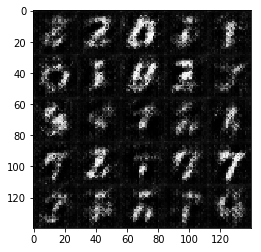

Epoch 1/2... Discriminator Loss: 1.4478... Generator Loss: 0.8268 Sum Loss: 2.2745
Epoch 1/2... Discriminator Loss: 1.3333... Generator Loss: 0.9138 Sum Loss: 2.2471
Epoch 1/2... Discriminator Loss: 1.4194... Generator Loss: 0.6021 Sum Loss: 2.0215
Epoch 1/2... Discriminator Loss: 1.4155... Generator Loss: 0.8596 Sum Loss: 2.2751
Epoch 1/2... Discriminator Loss: 1.4542... Generator Loss: 0.9246 Sum Loss: 2.3788
Epoch 1/2... Discriminator Loss: 1.3824... Generator Loss: 0.9228 Sum Loss: 2.3052
Epoch 1/2... Discriminator Loss: 1.4414... Generator Loss: 0.5579 Sum Loss: 1.9993
Epoch 1/2... Discriminator Loss: 1.3877... Generator Loss: 0.8904 Sum Loss: 2.2781
Epoch 1/2... Discriminator Loss: 1.4326... Generator Loss: 0.5869 Sum Loss: 2.0195
Epoch 1/2... Discriminator Loss: 1.3803... Generator Loss: 0.6711 Sum Loss: 2.0514


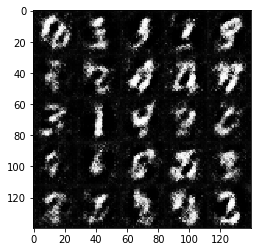

Epoch 1/2... Discriminator Loss: 1.3113... Generator Loss: 0.4616 Sum Loss: 1.7729
Epoch 1/2... Discriminator Loss: 1.4600... Generator Loss: 0.5866 Sum Loss: 2.0466
Epoch 1/2... Discriminator Loss: 1.3914... Generator Loss: 0.7815 Sum Loss: 2.1729
Epoch 1/2... Discriminator Loss: 1.4427... Generator Loss: 0.8669 Sum Loss: 2.3096
Epoch 1/2... Discriminator Loss: 1.4001... Generator Loss: 0.7665 Sum Loss: 2.1666
Epoch 1/2... Discriminator Loss: 1.3810... Generator Loss: 0.6390 Sum Loss: 2.0199
Epoch 1/2... Discriminator Loss: 1.4642... Generator Loss: 0.7748 Sum Loss: 2.2390
Epoch 1/2... Discriminator Loss: 1.3990... Generator Loss: 0.6320 Sum Loss: 2.0310
Epoch 1/2... Discriminator Loss: 1.3727... Generator Loss: 0.5957 Sum Loss: 1.9684
Epoch 1/2... Discriminator Loss: 1.4455... Generator Loss: 0.7088 Sum Loss: 2.1543


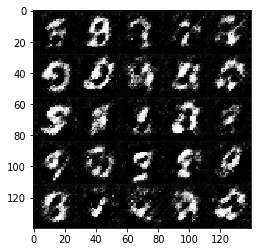

Epoch 1/2... Discriminator Loss: 1.4049... Generator Loss: 1.0026 Sum Loss: 2.4075
Epoch 1/2... Discriminator Loss: 1.4059... Generator Loss: 0.5215 Sum Loss: 1.9275
Epoch 1/2... Discriminator Loss: 1.7124... Generator Loss: 0.3556 Sum Loss: 2.0680
Epoch 1/2... Discriminator Loss: 1.3734... Generator Loss: 0.5797 Sum Loss: 1.9531
Epoch 1/2... Discriminator Loss: 1.4873... Generator Loss: 1.0062 Sum Loss: 2.4935
Epoch 1/2... Discriminator Loss: 1.5161... Generator Loss: 0.7467 Sum Loss: 2.2628
Epoch 1/2... Discriminator Loss: 1.4607... Generator Loss: 1.0185 Sum Loss: 2.4793
Epoch 1/2... Discriminator Loss: 1.4328... Generator Loss: 0.9781 Sum Loss: 2.4110
Epoch 1/2... Discriminator Loss: 1.4525... Generator Loss: 0.7546 Sum Loss: 2.2070
Epoch 1/2... Discriminator Loss: 1.3224... Generator Loss: 0.6566 Sum Loss: 1.9790


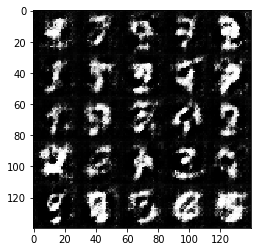

Epoch 1/2... Discriminator Loss: 1.4396... Generator Loss: 0.7427 Sum Loss: 2.1823
Epoch 1/2... Discriminator Loss: 1.3878... Generator Loss: 0.9462 Sum Loss: 2.3340
Epoch 1/2... Discriminator Loss: 1.4086... Generator Loss: 0.6287 Sum Loss: 2.0373
Epoch 1/2... Discriminator Loss: 1.3939... Generator Loss: 0.6289 Sum Loss: 2.0227
Epoch 1/2... Discriminator Loss: 1.4498... Generator Loss: 0.7787 Sum Loss: 2.2285
Epoch 1/2... Discriminator Loss: 1.3857... Generator Loss: 0.8446 Sum Loss: 2.2303
Epoch 1/2... Discriminator Loss: 1.3307... Generator Loss: 0.6730 Sum Loss: 2.0037
Epoch 1/2... Discriminator Loss: 1.3729... Generator Loss: 0.5547 Sum Loss: 1.9276
Epoch 1/2... Discriminator Loss: 1.4507... Generator Loss: 0.8608 Sum Loss: 2.3114
Epoch 1/2... Discriminator Loss: 1.4584... Generator Loss: 1.0712 Sum Loss: 2.5296


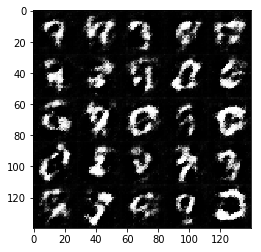

Epoch 1/2... Discriminator Loss: 1.4778... Generator Loss: 0.9002 Sum Loss: 2.3781
Epoch 1/2... Discriminator Loss: 1.3673... Generator Loss: 0.6791 Sum Loss: 2.0465
Epoch 1/2... Discriminator Loss: 1.3710... Generator Loss: 0.7957 Sum Loss: 2.1667
Epoch 1/2... Discriminator Loss: 1.4066... Generator Loss: 0.7283 Sum Loss: 2.1349
Epoch 1/2... Discriminator Loss: 1.4532... Generator Loss: 0.7915 Sum Loss: 2.2447
Epoch 1/2... Discriminator Loss: 1.3867... Generator Loss: 0.8458 Sum Loss: 2.2325
Epoch 1/2... Discriminator Loss: 1.5804... Generator Loss: 0.9655 Sum Loss: 2.5459
Epoch 1/2... Discriminator Loss: 1.4599... Generator Loss: 0.5281 Sum Loss: 1.9880
Epoch 1/2... Discriminator Loss: 1.3742... Generator Loss: 0.9835 Sum Loss: 2.3577
Epoch 1/2... Discriminator Loss: 1.4221... Generator Loss: 0.6787 Sum Loss: 2.1008


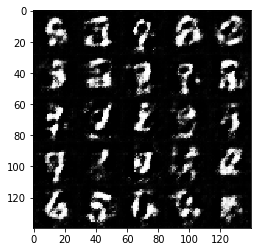

Epoch 1/2... Discriminator Loss: 1.4442... Generator Loss: 0.8721 Sum Loss: 2.3163
Epoch 1/2... Discriminator Loss: 1.4531... Generator Loss: 0.8862 Sum Loss: 2.3393
Epoch 1/2... Discriminator Loss: 1.3502... Generator Loss: 0.7378 Sum Loss: 2.0881
Epoch 1/2... Discriminator Loss: 1.3743... Generator Loss: 0.9734 Sum Loss: 2.3477
Epoch 1/2... Discriminator Loss: 1.3887... Generator Loss: 0.8024 Sum Loss: 2.1911
Epoch 1/2... Discriminator Loss: 1.3579... Generator Loss: 0.7699 Sum Loss: 2.1278
Epoch 1/2... Discriminator Loss: 1.3810... Generator Loss: 0.5932 Sum Loss: 1.9742
Epoch 1/2... Discriminator Loss: 1.4099... Generator Loss: 0.6326 Sum Loss: 2.0426
Epoch 1/2... Discriminator Loss: 1.3592... Generator Loss: 0.6706 Sum Loss: 2.0297
Epoch 1/2... Discriminator Loss: 1.4742... Generator Loss: 0.9521 Sum Loss: 2.4263


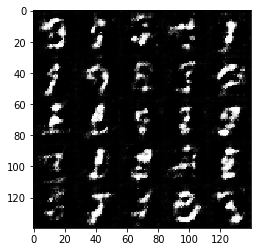

Epoch 1/2... Discriminator Loss: 1.3590... Generator Loss: 0.4697 Sum Loss: 1.8287
Epoch 1/2... Discriminator Loss: 1.3722... Generator Loss: 0.5977 Sum Loss: 1.9699
Epoch 1/2... Discriminator Loss: 1.4786... Generator Loss: 0.5373 Sum Loss: 2.0159
Epoch 2/2... Discriminator Loss: 1.3640... Generator Loss: 0.6881 Sum Loss: 2.0521
Epoch 2/2... Discriminator Loss: 1.4158... Generator Loss: 0.5993 Sum Loss: 2.0151
Epoch 2/2... Discriminator Loss: 1.3861... Generator Loss: 0.7023 Sum Loss: 2.0884
Epoch 2/2... Discriminator Loss: 1.3894... Generator Loss: 0.7411 Sum Loss: 2.1305
Epoch 2/2... Discriminator Loss: 1.4245... Generator Loss: 0.5570 Sum Loss: 1.9815
Epoch 2/2... Discriminator Loss: 1.3529... Generator Loss: 0.6609 Sum Loss: 2.0138
Epoch 2/2... Discriminator Loss: 1.3659... Generator Loss: 0.7543 Sum Loss: 2.1203


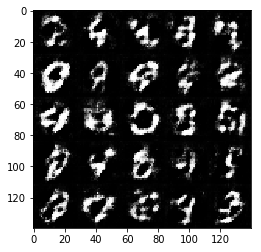

Epoch 2/2... Discriminator Loss: 1.3869... Generator Loss: 0.5795 Sum Loss: 1.9664
Epoch 2/2... Discriminator Loss: 1.5114... Generator Loss: 0.3843 Sum Loss: 1.8957
Epoch 2/2... Discriminator Loss: 1.3549... Generator Loss: 0.9031 Sum Loss: 2.2580
Epoch 2/2... Discriminator Loss: 1.3610... Generator Loss: 0.7589 Sum Loss: 2.1199
Epoch 2/2... Discriminator Loss: 1.3949... Generator Loss: 0.8138 Sum Loss: 2.2087
Epoch 2/2... Discriminator Loss: 1.4998... Generator Loss: 0.4419 Sum Loss: 1.9417
Epoch 2/2... Discriminator Loss: 1.3782... Generator Loss: 0.8846 Sum Loss: 2.2627
Epoch 2/2... Discriminator Loss: 1.4037... Generator Loss: 0.5957 Sum Loss: 1.9994
Epoch 2/2... Discriminator Loss: 1.4416... Generator Loss: 0.8586 Sum Loss: 2.3002
Epoch 2/2... Discriminator Loss: 1.4066... Generator Loss: 0.7413 Sum Loss: 2.1479


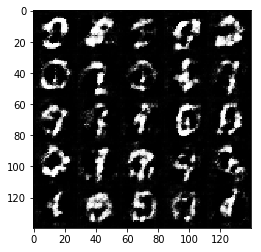

Epoch 2/2... Discriminator Loss: 1.3872... Generator Loss: 0.5799 Sum Loss: 1.9672
Epoch 2/2... Discriminator Loss: 1.3687... Generator Loss: 0.8873 Sum Loss: 2.2560
Epoch 2/2... Discriminator Loss: 1.4176... Generator Loss: 0.6705 Sum Loss: 2.0881
Epoch 2/2... Discriminator Loss: 1.4039... Generator Loss: 0.8728 Sum Loss: 2.2766
Epoch 2/2... Discriminator Loss: 1.5545... Generator Loss: 0.4642 Sum Loss: 2.0188
Epoch 2/2... Discriminator Loss: 1.4462... Generator Loss: 0.5345 Sum Loss: 1.9807
Epoch 2/2... Discriminator Loss: 1.3905... Generator Loss: 0.7204 Sum Loss: 2.1109
Epoch 2/2... Discriminator Loss: 1.4353... Generator Loss: 0.5461 Sum Loss: 1.9814
Epoch 2/2... Discriminator Loss: 1.4027... Generator Loss: 0.7423 Sum Loss: 2.1449
Epoch 2/2... Discriminator Loss: 1.3527... Generator Loss: 0.6770 Sum Loss: 2.0297


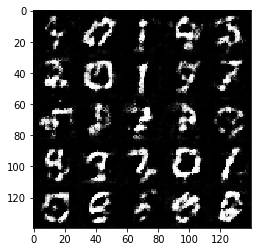

Epoch 2/2... Discriminator Loss: 1.3894... Generator Loss: 0.7544 Sum Loss: 2.1439
Epoch 2/2... Discriminator Loss: 1.4812... Generator Loss: 1.0105 Sum Loss: 2.4916
Epoch 2/2... Discriminator Loss: 1.5103... Generator Loss: 0.9087 Sum Loss: 2.4190
Epoch 2/2... Discriminator Loss: 1.3779... Generator Loss: 0.4644 Sum Loss: 1.8423
Epoch 2/2... Discriminator Loss: 1.3226... Generator Loss: 0.6854 Sum Loss: 2.0080
Epoch 2/2... Discriminator Loss: 1.3554... Generator Loss: 0.6028 Sum Loss: 1.9582
Epoch 2/2... Discriminator Loss: 1.4885... Generator Loss: 0.7449 Sum Loss: 2.2334
Epoch 2/2... Discriminator Loss: 1.3646... Generator Loss: 0.6797 Sum Loss: 2.0442
Epoch 2/2... Discriminator Loss: 1.3751... Generator Loss: 0.7734 Sum Loss: 2.1485
Epoch 2/2... Discriminator Loss: 1.4176... Generator Loss: 0.6273 Sum Loss: 2.0450


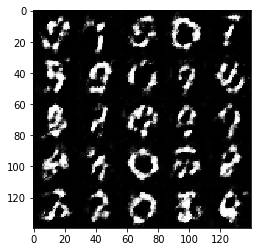

Epoch 2/2... Discriminator Loss: 1.5000... Generator Loss: 0.4643 Sum Loss: 1.9643
Epoch 2/2... Discriminator Loss: 1.3584... Generator Loss: 0.7611 Sum Loss: 2.1196
Epoch 2/2... Discriminator Loss: 1.4701... Generator Loss: 0.4811 Sum Loss: 1.9513
Epoch 2/2... Discriminator Loss: 1.4219... Generator Loss: 0.6266 Sum Loss: 2.0485
Epoch 2/2... Discriminator Loss: 1.5436... Generator Loss: 0.9937 Sum Loss: 2.5373
Epoch 2/2... Discriminator Loss: 1.3506... Generator Loss: 0.6836 Sum Loss: 2.0342
Epoch 2/2... Discriminator Loss: 1.3870... Generator Loss: 0.7049 Sum Loss: 2.0920
Epoch 2/2... Discriminator Loss: 1.3900... Generator Loss: 0.6420 Sum Loss: 2.0320
Epoch 2/2... Discriminator Loss: 1.3781... Generator Loss: 0.6232 Sum Loss: 2.0013
Epoch 2/2... Discriminator Loss: 1.4016... Generator Loss: 0.8355 Sum Loss: 2.2370


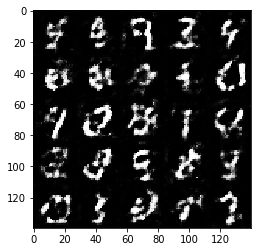

Epoch 2/2... Discriminator Loss: 1.3969... Generator Loss: 0.6526 Sum Loss: 2.0495
Epoch 2/2... Discriminator Loss: 1.3693... Generator Loss: 0.5863 Sum Loss: 1.9556
Epoch 2/2... Discriminator Loss: 1.3350... Generator Loss: 0.6932 Sum Loss: 2.0281
Epoch 2/2... Discriminator Loss: 1.3946... Generator Loss: 0.7851 Sum Loss: 2.1798
Epoch 2/2... Discriminator Loss: 1.4059... Generator Loss: 0.5551 Sum Loss: 1.9609
Epoch 2/2... Discriminator Loss: 1.5495... Generator Loss: 0.4531 Sum Loss: 2.0026
Epoch 2/2... Discriminator Loss: 1.3652... Generator Loss: 1.0611 Sum Loss: 2.4264
Epoch 2/2... Discriminator Loss: 1.3714... Generator Loss: 0.6678 Sum Loss: 2.0392
Epoch 2/2... Discriminator Loss: 1.4423... Generator Loss: 0.6322 Sum Loss: 2.0745
Epoch 2/2... Discriminator Loss: 1.3671... Generator Loss: 0.4900 Sum Loss: 1.8571


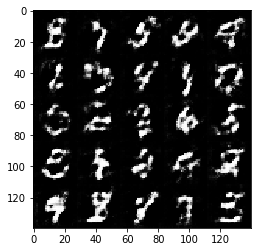

Epoch 2/2... Discriminator Loss: 1.4701... Generator Loss: 0.7124 Sum Loss: 2.1825
Epoch 2/2... Discriminator Loss: 1.3906... Generator Loss: 0.7957 Sum Loss: 2.1863
Epoch 2/2... Discriminator Loss: 1.4129... Generator Loss: 0.6257 Sum Loss: 2.0386
Epoch 2/2... Discriminator Loss: 1.4014... Generator Loss: 0.6347 Sum Loss: 2.0361
Epoch 2/2... Discriminator Loss: 1.4443... Generator Loss: 0.7269 Sum Loss: 2.1712
Epoch 2/2... Discriminator Loss: 1.3756... Generator Loss: 0.7010 Sum Loss: 2.0766
Epoch 2/2... Discriminator Loss: 1.4277... Generator Loss: 0.5507 Sum Loss: 1.9784
Epoch 2/2... Discriminator Loss: 1.4385... Generator Loss: 0.5010 Sum Loss: 1.9394
Epoch 2/2... Discriminator Loss: 1.4220... Generator Loss: 0.8428 Sum Loss: 2.2648
Epoch 2/2... Discriminator Loss: 1.3231... Generator Loss: 0.9017 Sum Loss: 2.2248


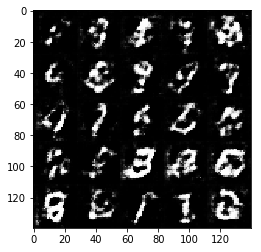

Epoch 2/2... Discriminator Loss: 1.5031... Generator Loss: 0.5127 Sum Loss: 2.0159
Epoch 2/2... Discriminator Loss: 1.3779... Generator Loss: 0.6403 Sum Loss: 2.0182
Epoch 2/2... Discriminator Loss: 1.4076... Generator Loss: 0.6092 Sum Loss: 2.0169
Epoch 2/2... Discriminator Loss: 1.4560... Generator Loss: 0.5904 Sum Loss: 2.0464
Epoch 2/2... Discriminator Loss: 1.3916... Generator Loss: 0.7919 Sum Loss: 2.1835
Epoch 2/2... Discriminator Loss: 1.3715... Generator Loss: 0.4270 Sum Loss: 1.7984
Epoch 2/2... Discriminator Loss: 1.3839... Generator Loss: 0.6125 Sum Loss: 1.9964
Epoch 2/2... Discriminator Loss: 1.3548... Generator Loss: 0.5255 Sum Loss: 1.8803
Epoch 2/2... Discriminator Loss: 1.3631... Generator Loss: 0.5893 Sum Loss: 1.9524
Epoch 2/2... Discriminator Loss: 1.4887... Generator Loss: 0.7459 Sum Loss: 2.2346


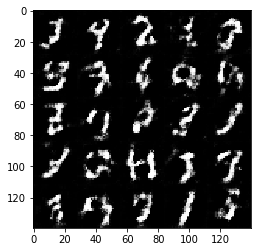

Epoch 2/2... Discriminator Loss: 1.5103... Generator Loss: 0.4753 Sum Loss: 1.9857
Epoch 2/2... Discriminator Loss: 1.4174... Generator Loss: 0.5676 Sum Loss: 1.9850
Epoch 2/2... Discriminator Loss: 1.4519... Generator Loss: 0.5721 Sum Loss: 2.0239
Epoch 2/2... Discriminator Loss: 1.3491... Generator Loss: 0.8826 Sum Loss: 2.2317
Epoch 2/2... Discriminator Loss: 1.4172... Generator Loss: 0.6461 Sum Loss: 2.0634
Epoch 2/2... Discriminator Loss: 1.4120... Generator Loss: 0.7839 Sum Loss: 2.1959
Epoch 2/2... Discriminator Loss: 1.3648... Generator Loss: 0.6800 Sum Loss: 2.0448
Epoch 2/2... Discriminator Loss: 1.4086... Generator Loss: 0.9204 Sum Loss: 2.3291
Epoch 2/2... Discriminator Loss: 1.3786... Generator Loss: 0.7954 Sum Loss: 2.1740
Epoch 2/2... Discriminator Loss: 1.3374... Generator Loss: 0.6199 Sum Loss: 1.9573


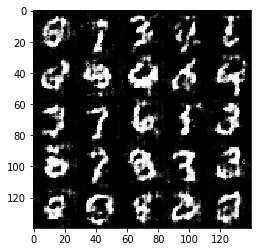

Epoch 2/2... Discriminator Loss: 1.4416... Generator Loss: 0.5715 Sum Loss: 2.0131
Epoch 2/2... Discriminator Loss: 1.3223... Generator Loss: 0.6475 Sum Loss: 1.9697
Epoch 2/2... Discriminator Loss: 1.4115... Generator Loss: 0.6555 Sum Loss: 2.0670
Epoch 2/2... Discriminator Loss: 1.3853... Generator Loss: 0.6960 Sum Loss: 2.0813
Epoch 2/2... Discriminator Loss: 1.5219... Generator Loss: 0.8876 Sum Loss: 2.4095
Epoch 2/2... Discriminator Loss: 1.3270... Generator Loss: 0.7284 Sum Loss: 2.0554
Epoch 2/2... Discriminator Loss: 1.4051... Generator Loss: 0.7128 Sum Loss: 2.1179


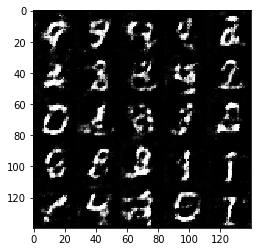

In [46]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 4.7719... Generator Loss: 0.0114 Sum Loss: 4.7833
Epoch 1/1... Discriminator Loss: 4.3963... Generator Loss: 0.0160 Sum Loss: 4.4122
Epoch 1/1... Discriminator Loss: 4.0189... Generator Loss: 0.0232 Sum Loss: 4.0421
Epoch 1/1... Discriminator Loss: 3.7121... Generator Loss: 0.0398 Sum Loss: 3.7518
Epoch 1/1... Discriminator Loss: 3.1382... Generator Loss: 0.0987 Sum Loss: 3.2370
Epoch 1/1... Discriminator Loss: 2.7231... Generator Loss: 0.1182 Sum Loss: 2.8413
Epoch 1/1... Discriminator Loss: 2.1325... Generator Loss: 0.4297 Sum Loss: 2.5622
Epoch 1/1... Discriminator Loss: 2.4158... Generator Loss: 0.3115 Sum Loss: 2.7273
Epoch 1/1... Discriminator Loss: 2.1681... Generator Loss: 0.4184 Sum Loss: 2.5865
Epoch 1/1... Discriminator Loss: 2.1247... Generator Loss: 0.3613 Sum Loss: 2.4860


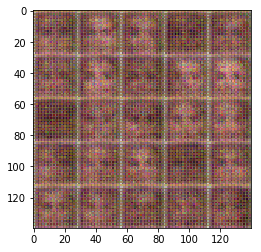

Epoch 1/1... Discriminator Loss: 2.0084... Generator Loss: 0.5481 Sum Loss: 2.5565
Epoch 1/1... Discriminator Loss: 1.9678... Generator Loss: 0.4920 Sum Loss: 2.4599
Epoch 1/1... Discriminator Loss: 2.0578... Generator Loss: 0.5462 Sum Loss: 2.6039
Epoch 1/1... Discriminator Loss: 2.1106... Generator Loss: 0.6028 Sum Loss: 2.7134
Epoch 1/1... Discriminator Loss: 1.9614... Generator Loss: 0.4488 Sum Loss: 2.4102
Epoch 1/1... Discriminator Loss: 1.8949... Generator Loss: 0.4387 Sum Loss: 2.3336
Epoch 1/1... Discriminator Loss: 1.9469... Generator Loss: 0.5415 Sum Loss: 2.4884
Epoch 1/1... Discriminator Loss: 1.7712... Generator Loss: 0.5854 Sum Loss: 2.3566
Epoch 1/1... Discriminator Loss: 1.6895... Generator Loss: 0.5190 Sum Loss: 2.2085
Epoch 1/1... Discriminator Loss: 1.7510... Generator Loss: 0.5129 Sum Loss: 2.2640


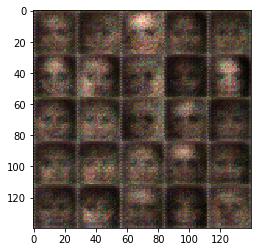

Epoch 1/1... Discriminator Loss: 1.7297... Generator Loss: 0.5379 Sum Loss: 2.2676
Epoch 1/1... Discriminator Loss: 1.6842... Generator Loss: 0.6484 Sum Loss: 2.3326
Epoch 1/1... Discriminator Loss: 1.7347... Generator Loss: 0.6199 Sum Loss: 2.3546
Epoch 1/1... Discriminator Loss: 1.6908... Generator Loss: 0.4752 Sum Loss: 2.1659
Epoch 1/1... Discriminator Loss: 1.7779... Generator Loss: 0.5482 Sum Loss: 2.3262
Epoch 1/1... Discriminator Loss: 1.7151... Generator Loss: 0.5279 Sum Loss: 2.2430
Epoch 1/1... Discriminator Loss: 1.7957... Generator Loss: 0.5174 Sum Loss: 2.3131
Epoch 1/1... Discriminator Loss: 1.7497... Generator Loss: 0.6112 Sum Loss: 2.3609
Epoch 1/1... Discriminator Loss: 1.6605... Generator Loss: 0.4730 Sum Loss: 2.1335
Epoch 1/1... Discriminator Loss: 1.6912... Generator Loss: 0.6481 Sum Loss: 2.3394


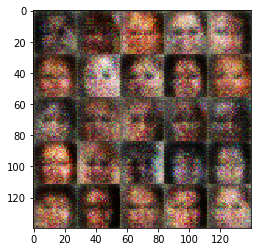

Epoch 1/1... Discriminator Loss: 1.6133... Generator Loss: 0.5731 Sum Loss: 2.1865
Epoch 1/1... Discriminator Loss: 1.6231... Generator Loss: 0.6434 Sum Loss: 2.2664
Epoch 1/1... Discriminator Loss: 1.6392... Generator Loss: 0.6115 Sum Loss: 2.2508
Epoch 1/1... Discriminator Loss: 1.6632... Generator Loss: 0.6029 Sum Loss: 2.2661
Epoch 1/1... Discriminator Loss: 1.7139... Generator Loss: 0.5690 Sum Loss: 2.2828
Epoch 1/1... Discriminator Loss: 1.6505... Generator Loss: 0.6310 Sum Loss: 2.2816
Epoch 1/1... Discriminator Loss: 1.5940... Generator Loss: 0.5600 Sum Loss: 2.1540
Epoch 1/1... Discriminator Loss: 1.6033... Generator Loss: 0.5614 Sum Loss: 2.1648
Epoch 1/1... Discriminator Loss: 1.6153... Generator Loss: 0.5727 Sum Loss: 2.1880
Epoch 1/1... Discriminator Loss: 1.5835... Generator Loss: 0.5521 Sum Loss: 2.1356


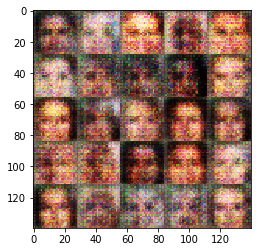

Epoch 1/1... Discriminator Loss: 1.5840... Generator Loss: 0.5763 Sum Loss: 2.1603
Epoch 1/1... Discriminator Loss: 1.5095... Generator Loss: 0.6373 Sum Loss: 2.1468
Epoch 1/1... Discriminator Loss: 1.6074... Generator Loss: 0.5109 Sum Loss: 2.1183
Epoch 1/1... Discriminator Loss: 1.5969... Generator Loss: 0.5317 Sum Loss: 2.1286
Epoch 1/1... Discriminator Loss: 1.5088... Generator Loss: 0.6671 Sum Loss: 2.1759
Epoch 1/1... Discriminator Loss: 1.5525... Generator Loss: 0.5294 Sum Loss: 2.0819
Epoch 1/1... Discriminator Loss: 1.5852... Generator Loss: 0.4680 Sum Loss: 2.0533
Epoch 1/1... Discriminator Loss: 1.5870... Generator Loss: 0.4646 Sum Loss: 2.0516
Epoch 1/1... Discriminator Loss: 1.7104... Generator Loss: 0.8110 Sum Loss: 2.5214
Epoch 1/1... Discriminator Loss: 1.5572... Generator Loss: 0.6017 Sum Loss: 2.1589


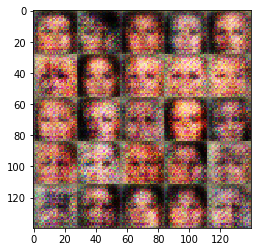

Epoch 1/1... Discriminator Loss: 1.6058... Generator Loss: 0.5754 Sum Loss: 2.1812
Epoch 1/1... Discriminator Loss: 1.5200... Generator Loss: 0.5977 Sum Loss: 2.1177
Epoch 1/1... Discriminator Loss: 1.4622... Generator Loss: 0.5778 Sum Loss: 2.0400
Epoch 1/1... Discriminator Loss: 1.4755... Generator Loss: 0.7318 Sum Loss: 2.2073
Epoch 1/1... Discriminator Loss: 1.5519... Generator Loss: 0.7716 Sum Loss: 2.3235
Epoch 1/1... Discriminator Loss: 1.5257... Generator Loss: 0.5460 Sum Loss: 2.0717
Epoch 1/1... Discriminator Loss: 1.5282... Generator Loss: 0.6082 Sum Loss: 2.1364
Epoch 1/1... Discriminator Loss: 1.5074... Generator Loss: 0.6629 Sum Loss: 2.1704
Epoch 1/1... Discriminator Loss: 1.4778... Generator Loss: 0.5915 Sum Loss: 2.0693
Epoch 1/1... Discriminator Loss: 1.4979... Generator Loss: 0.6015 Sum Loss: 2.0994


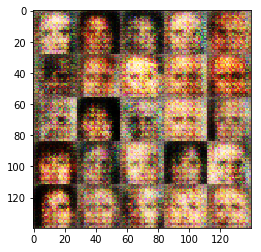

Epoch 1/1... Discriminator Loss: 1.4822... Generator Loss: 0.6495 Sum Loss: 2.1317
Epoch 1/1... Discriminator Loss: 1.5334... Generator Loss: 0.6506 Sum Loss: 2.1840
Epoch 1/1... Discriminator Loss: 1.5513... Generator Loss: 0.4827 Sum Loss: 2.0340
Epoch 1/1... Discriminator Loss: 1.5366... Generator Loss: 0.6957 Sum Loss: 2.2324
Epoch 1/1... Discriminator Loss: 1.4229... Generator Loss: 0.5206 Sum Loss: 1.9435
Epoch 1/1... Discriminator Loss: 1.4208... Generator Loss: 0.6017 Sum Loss: 2.0225
Epoch 1/1... Discriminator Loss: 1.4885... Generator Loss: 0.5329 Sum Loss: 2.0215
Epoch 1/1... Discriminator Loss: 1.6136... Generator Loss: 0.8567 Sum Loss: 2.4703
Epoch 1/1... Discriminator Loss: 1.4719... Generator Loss: 0.6583 Sum Loss: 2.1302
Epoch 1/1... Discriminator Loss: 1.5893... Generator Loss: 0.4787 Sum Loss: 2.0680


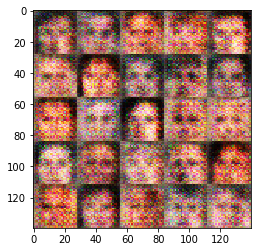

Epoch 1/1... Discriminator Loss: 1.5127... Generator Loss: 0.7383 Sum Loss: 2.2510
Epoch 1/1... Discriminator Loss: 1.4818... Generator Loss: 0.6182 Sum Loss: 2.1000
Epoch 1/1... Discriminator Loss: 1.4750... Generator Loss: 0.5797 Sum Loss: 2.0547
Epoch 1/1... Discriminator Loss: 1.5511... Generator Loss: 0.8378 Sum Loss: 2.3889
Epoch 1/1... Discriminator Loss: 1.4787... Generator Loss: 0.6285 Sum Loss: 2.1072
Epoch 1/1... Discriminator Loss: 1.4577... Generator Loss: 0.6336 Sum Loss: 2.0912
Epoch 1/1... Discriminator Loss: 1.5013... Generator Loss: 0.6401 Sum Loss: 2.1414
Epoch 1/1... Discriminator Loss: 1.4716... Generator Loss: 0.5498 Sum Loss: 2.0214
Epoch 1/1... Discriminator Loss: 1.5163... Generator Loss: 0.8194 Sum Loss: 2.3357
Epoch 1/1... Discriminator Loss: 1.5110... Generator Loss: 0.5438 Sum Loss: 2.0548


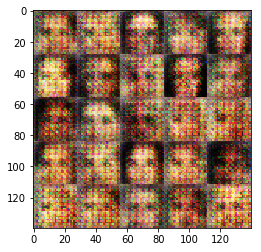

Epoch 1/1... Discriminator Loss: 1.4619... Generator Loss: 0.6042 Sum Loss: 2.0661
Epoch 1/1... Discriminator Loss: 1.4862... Generator Loss: 0.6725 Sum Loss: 2.1587
Epoch 1/1... Discriminator Loss: 1.5392... Generator Loss: 0.8111 Sum Loss: 2.3504
Epoch 1/1... Discriminator Loss: 1.4228... Generator Loss: 0.6834 Sum Loss: 2.1062
Epoch 1/1... Discriminator Loss: 1.5028... Generator Loss: 0.5746 Sum Loss: 2.0774
Epoch 1/1... Discriminator Loss: 1.5007... Generator Loss: 0.8183 Sum Loss: 2.3190
Epoch 1/1... Discriminator Loss: 1.4405... Generator Loss: 0.6300 Sum Loss: 2.0705
Epoch 1/1... Discriminator Loss: 1.4886... Generator Loss: 0.8251 Sum Loss: 2.3137
Epoch 1/1... Discriminator Loss: 1.4766... Generator Loss: 0.7114 Sum Loss: 2.1880
Epoch 1/1... Discriminator Loss: 1.4607... Generator Loss: 0.5877 Sum Loss: 2.0484


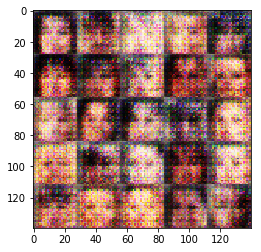

Epoch 1/1... Discriminator Loss: 1.4543... Generator Loss: 0.7908 Sum Loss: 2.2451
Epoch 1/1... Discriminator Loss: 1.5410... Generator Loss: 0.8410 Sum Loss: 2.3819
Epoch 1/1... Discriminator Loss: 1.4598... Generator Loss: 0.6225 Sum Loss: 2.0823
Epoch 1/1... Discriminator Loss: 1.4834... Generator Loss: 0.5213 Sum Loss: 2.0047
Epoch 1/1... Discriminator Loss: 1.4556... Generator Loss: 0.6324 Sum Loss: 2.0880
Epoch 1/1... Discriminator Loss: 1.4523... Generator Loss: 0.6473 Sum Loss: 2.0997
Epoch 1/1... Discriminator Loss: 1.4269... Generator Loss: 0.6065 Sum Loss: 2.0334
Epoch 1/1... Discriminator Loss: 1.4986... Generator Loss: 0.8922 Sum Loss: 2.3908
Epoch 1/1... Discriminator Loss: 1.4737... Generator Loss: 0.7872 Sum Loss: 2.2609
Epoch 1/1... Discriminator Loss: 1.5146... Generator Loss: 0.5864 Sum Loss: 2.1010


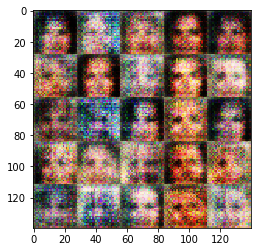

Epoch 1/1... Discriminator Loss: 1.4638... Generator Loss: 0.6898 Sum Loss: 2.1536
Epoch 1/1... Discriminator Loss: 1.4299... Generator Loss: 0.6903 Sum Loss: 2.1202
Epoch 1/1... Discriminator Loss: 1.3961... Generator Loss: 0.7369 Sum Loss: 2.1329
Epoch 1/1... Discriminator Loss: 1.4299... Generator Loss: 0.5989 Sum Loss: 2.0288
Epoch 1/1... Discriminator Loss: 1.5209... Generator Loss: 0.8300 Sum Loss: 2.3509
Epoch 1/1... Discriminator Loss: 1.4393... Generator Loss: 0.7102 Sum Loss: 2.1496
Epoch 1/1... Discriminator Loss: 1.3723... Generator Loss: 0.6565 Sum Loss: 2.0289
Epoch 1/1... Discriminator Loss: 1.4903... Generator Loss: 0.5258 Sum Loss: 2.0161
Epoch 1/1... Discriminator Loss: 1.4685... Generator Loss: 0.5611 Sum Loss: 2.0296
Epoch 1/1... Discriminator Loss: 1.4566... Generator Loss: 0.6154 Sum Loss: 2.0720


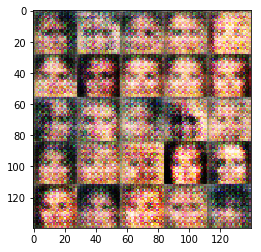

Epoch 1/1... Discriminator Loss: 1.4163... Generator Loss: 0.8232 Sum Loss: 2.2396
Epoch 1/1... Discriminator Loss: 1.3951... Generator Loss: 0.6352 Sum Loss: 2.0303
Epoch 1/1... Discriminator Loss: 1.4455... Generator Loss: 0.7964 Sum Loss: 2.2419
Epoch 1/1... Discriminator Loss: 1.3988... Generator Loss: 0.7010 Sum Loss: 2.0998
Epoch 1/1... Discriminator Loss: 1.4865... Generator Loss: 0.7470 Sum Loss: 2.2335
Epoch 1/1... Discriminator Loss: 1.4420... Generator Loss: 0.5630 Sum Loss: 2.0050
Epoch 1/1... Discriminator Loss: 1.4545... Generator Loss: 0.5717 Sum Loss: 2.0262
Epoch 1/1... Discriminator Loss: 1.4704... Generator Loss: 0.6301 Sum Loss: 2.1005
Epoch 1/1... Discriminator Loss: 1.4770... Generator Loss: 0.6148 Sum Loss: 2.0918
Epoch 1/1... Discriminator Loss: 1.4193... Generator Loss: 0.6412 Sum Loss: 2.0605


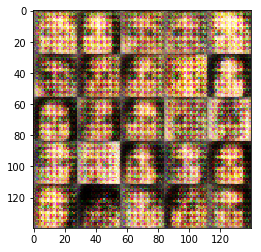

Epoch 1/1... Discriminator Loss: 1.4654... Generator Loss: 0.6617 Sum Loss: 2.1272
Epoch 1/1... Discriminator Loss: 1.4525... Generator Loss: 0.6156 Sum Loss: 2.0682
Epoch 1/1... Discriminator Loss: 1.4482... Generator Loss: 0.6250 Sum Loss: 2.0732
Epoch 1/1... Discriminator Loss: 1.4959... Generator Loss: 0.6843 Sum Loss: 2.1802
Epoch 1/1... Discriminator Loss: 1.4166... Generator Loss: 0.6754 Sum Loss: 2.0920
Epoch 1/1... Discriminator Loss: 1.4725... Generator Loss: 0.6673 Sum Loss: 2.1398
Epoch 1/1... Discriminator Loss: 1.4584... Generator Loss: 0.7508 Sum Loss: 2.2092
Epoch 1/1... Discriminator Loss: 1.4538... Generator Loss: 0.6260 Sum Loss: 2.0798
Epoch 1/1... Discriminator Loss: 1.4011... Generator Loss: 0.7226 Sum Loss: 2.1236
Epoch 1/1... Discriminator Loss: 1.4362... Generator Loss: 0.6919 Sum Loss: 2.1281


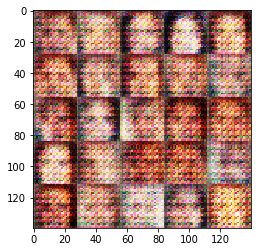

Epoch 1/1... Discriminator Loss: 1.4490... Generator Loss: 0.5782 Sum Loss: 2.0271
Epoch 1/1... Discriminator Loss: 1.4356... Generator Loss: 0.6796 Sum Loss: 2.1153
Epoch 1/1... Discriminator Loss: 1.3676... Generator Loss: 0.5392 Sum Loss: 1.9068
Epoch 1/1... Discriminator Loss: 1.4326... Generator Loss: 0.6954 Sum Loss: 2.1280
Epoch 1/1... Discriminator Loss: 1.5766... Generator Loss: 0.8608 Sum Loss: 2.4374
Epoch 1/1... Discriminator Loss: 1.4405... Generator Loss: 0.7503 Sum Loss: 2.1908
Epoch 1/1... Discriminator Loss: 1.3319... Generator Loss: 0.4733 Sum Loss: 1.8052
Epoch 1/1... Discriminator Loss: 1.3868... Generator Loss: 0.6699 Sum Loss: 2.0567
Epoch 1/1... Discriminator Loss: 1.3956... Generator Loss: 0.6790 Sum Loss: 2.0746
Epoch 1/1... Discriminator Loss: 1.3793... Generator Loss: 0.6483 Sum Loss: 2.0276


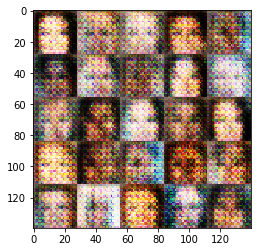

Epoch 1/1... Discriminator Loss: 1.5033... Generator Loss: 0.5431 Sum Loss: 2.0464
Epoch 1/1... Discriminator Loss: 1.3845... Generator Loss: 0.7370 Sum Loss: 2.1215
Epoch 1/1... Discriminator Loss: 1.4405... Generator Loss: 0.6335 Sum Loss: 2.0740
Epoch 1/1... Discriminator Loss: 1.4697... Generator Loss: 0.6462 Sum Loss: 2.1159
Epoch 1/1... Discriminator Loss: 1.4273... Generator Loss: 0.6945 Sum Loss: 2.1218
Epoch 1/1... Discriminator Loss: 1.4417... Generator Loss: 0.6510 Sum Loss: 2.0927
Epoch 1/1... Discriminator Loss: 1.4868... Generator Loss: 0.6880 Sum Loss: 2.1748
Epoch 1/1... Discriminator Loss: 1.4203... Generator Loss: 0.7638 Sum Loss: 2.1841
Epoch 1/1... Discriminator Loss: 1.4170... Generator Loss: 0.5000 Sum Loss: 1.9170
Epoch 1/1... Discriminator Loss: 1.3866... Generator Loss: 0.6540 Sum Loss: 2.0406


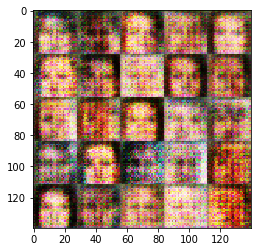

Epoch 1/1... Discriminator Loss: 1.4368... Generator Loss: 0.6764 Sum Loss: 2.1132
Epoch 1/1... Discriminator Loss: 1.4291... Generator Loss: 0.6272 Sum Loss: 2.0563
Epoch 1/1... Discriminator Loss: 1.4237... Generator Loss: 0.7025 Sum Loss: 2.1262
Epoch 1/1... Discriminator Loss: 1.4056... Generator Loss: 0.6393 Sum Loss: 2.0448
Epoch 1/1... Discriminator Loss: 1.4369... Generator Loss: 0.6627 Sum Loss: 2.0996
Epoch 1/1... Discriminator Loss: 1.4759... Generator Loss: 0.8224 Sum Loss: 2.2983
Epoch 1/1... Discriminator Loss: 1.3911... Generator Loss: 0.6569 Sum Loss: 2.0480
Epoch 1/1... Discriminator Loss: 1.4325... Generator Loss: 0.7651 Sum Loss: 2.1976
Epoch 1/1... Discriminator Loss: 1.5248... Generator Loss: 0.8218 Sum Loss: 2.3467
Epoch 1/1... Discriminator Loss: 1.4471... Generator Loss: 0.6658 Sum Loss: 2.1129


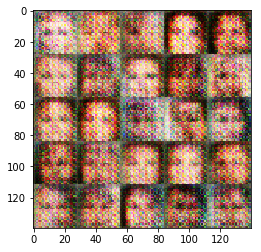

Epoch 1/1... Discriminator Loss: 1.4877... Generator Loss: 0.7357 Sum Loss: 2.2233
Epoch 1/1... Discriminator Loss: 1.4753... Generator Loss: 0.8188 Sum Loss: 2.2941
Epoch 1/1... Discriminator Loss: 1.4007... Generator Loss: 0.6404 Sum Loss: 2.0411
Epoch 1/1... Discriminator Loss: 1.4247... Generator Loss: 0.7413 Sum Loss: 2.1659
Epoch 1/1... Discriminator Loss: 1.4581... Generator Loss: 0.6023 Sum Loss: 2.0604
Epoch 1/1... Discriminator Loss: 1.4564... Generator Loss: 0.8635 Sum Loss: 2.3198
Epoch 1/1... Discriminator Loss: 1.4427... Generator Loss: 0.7693 Sum Loss: 2.2120
Epoch 1/1... Discriminator Loss: 1.4321... Generator Loss: 0.6926 Sum Loss: 2.1246
Epoch 1/1... Discriminator Loss: 1.4560... Generator Loss: 0.5863 Sum Loss: 2.0423
Epoch 1/1... Discriminator Loss: 1.3586... Generator Loss: 0.7052 Sum Loss: 2.0638


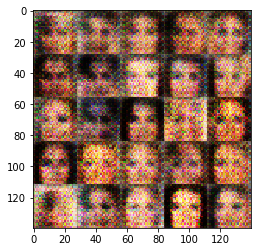

Epoch 1/1... Discriminator Loss: 1.4449... Generator Loss: 0.6734 Sum Loss: 2.1183
Epoch 1/1... Discriminator Loss: 1.4391... Generator Loss: 0.5880 Sum Loss: 2.0271
Epoch 1/1... Discriminator Loss: 1.4561... Generator Loss: 0.6521 Sum Loss: 2.1082
Epoch 1/1... Discriminator Loss: 1.4078... Generator Loss: 0.6315 Sum Loss: 2.0393
Epoch 1/1... Discriminator Loss: 1.4342... Generator Loss: 0.7191 Sum Loss: 2.1533
Epoch 1/1... Discriminator Loss: 1.3927... Generator Loss: 0.7458 Sum Loss: 2.1385
Epoch 1/1... Discriminator Loss: 1.4307... Generator Loss: 0.6646 Sum Loss: 2.0954
Epoch 1/1... Discriminator Loss: 1.4520... Generator Loss: 0.7917 Sum Loss: 2.2437
Epoch 1/1... Discriminator Loss: 1.4220... Generator Loss: 0.6042 Sum Loss: 2.0262
Epoch 1/1... Discriminator Loss: 1.3729... Generator Loss: 0.7327 Sum Loss: 2.1055


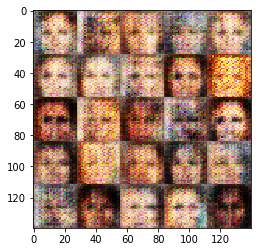

Epoch 1/1... Discriminator Loss: 1.4620... Generator Loss: 0.6911 Sum Loss: 2.1531
Epoch 1/1... Discriminator Loss: 1.4273... Generator Loss: 0.8541 Sum Loss: 2.2814
Epoch 1/1... Discriminator Loss: 1.4148... Generator Loss: 0.6703 Sum Loss: 2.0851
Epoch 1/1... Discriminator Loss: 1.3684... Generator Loss: 0.8060 Sum Loss: 2.1744
Epoch 1/1... Discriminator Loss: 1.5579... Generator Loss: 0.7704 Sum Loss: 2.3283
Epoch 1/1... Discriminator Loss: 1.3757... Generator Loss: 0.8054 Sum Loss: 2.1811
Epoch 1/1... Discriminator Loss: 1.3984... Generator Loss: 0.5738 Sum Loss: 1.9721
Epoch 1/1... Discriminator Loss: 1.4074... Generator Loss: 0.6327 Sum Loss: 2.0401
Epoch 1/1... Discriminator Loss: 1.3901... Generator Loss: 0.6259 Sum Loss: 2.0160
Epoch 1/1... Discriminator Loss: 1.4324... Generator Loss: 0.7486 Sum Loss: 2.1811


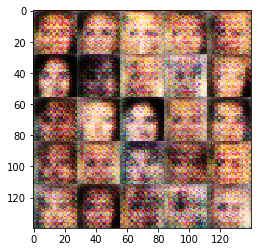

Epoch 1/1... Discriminator Loss: 1.3931... Generator Loss: 0.8907 Sum Loss: 2.2838
Epoch 1/1... Discriminator Loss: 1.4065... Generator Loss: 0.6883 Sum Loss: 2.0948
Epoch 1/1... Discriminator Loss: 1.4101... Generator Loss: 0.7684 Sum Loss: 2.1786
Epoch 1/1... Discriminator Loss: 1.4478... Generator Loss: 0.6980 Sum Loss: 2.1458
Epoch 1/1... Discriminator Loss: 1.3886... Generator Loss: 0.7360 Sum Loss: 2.1246
Epoch 1/1... Discriminator Loss: 1.4828... Generator Loss: 0.5869 Sum Loss: 2.0697
Epoch 1/1... Discriminator Loss: 1.4148... Generator Loss: 0.5931 Sum Loss: 2.0079
Epoch 1/1... Discriminator Loss: 1.4383... Generator Loss: 0.6639 Sum Loss: 2.1022
Epoch 1/1... Discriminator Loss: 1.4162... Generator Loss: 0.6235 Sum Loss: 2.0397
Epoch 1/1... Discriminator Loss: 1.4396... Generator Loss: 0.7229 Sum Loss: 2.1625


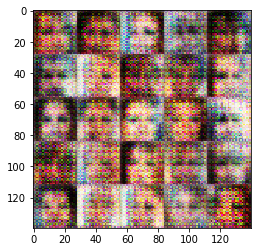

Epoch 1/1... Discriminator Loss: 1.3738... Generator Loss: 0.7513 Sum Loss: 2.1251
Epoch 1/1... Discriminator Loss: 1.4698... Generator Loss: 0.8236 Sum Loss: 2.2934
Epoch 1/1... Discriminator Loss: 1.3930... Generator Loss: 0.6096 Sum Loss: 2.0026
Epoch 1/1... Discriminator Loss: 1.4387... Generator Loss: 0.7771 Sum Loss: 2.2158
Epoch 1/1... Discriminator Loss: 1.4412... Generator Loss: 0.5641 Sum Loss: 2.0053
Epoch 1/1... Discriminator Loss: 1.4004... Generator Loss: 0.6649 Sum Loss: 2.0653
Epoch 1/1... Discriminator Loss: 1.4011... Generator Loss: 0.7270 Sum Loss: 2.1281
Epoch 1/1... Discriminator Loss: 1.4465... Generator Loss: 0.7742 Sum Loss: 2.2208
Epoch 1/1... Discriminator Loss: 1.4870... Generator Loss: 0.7503 Sum Loss: 2.2373
Epoch 1/1... Discriminator Loss: 1.3973... Generator Loss: 0.6434 Sum Loss: 2.0406


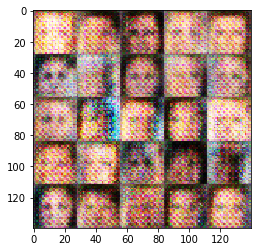

Epoch 1/1... Discriminator Loss: 1.3820... Generator Loss: 0.7871 Sum Loss: 2.1692
Epoch 1/1... Discriminator Loss: 1.3838... Generator Loss: 0.7657 Sum Loss: 2.1495
Epoch 1/1... Discriminator Loss: 1.4919... Generator Loss: 0.7604 Sum Loss: 2.2523
Epoch 1/1... Discriminator Loss: 1.5754... Generator Loss: 0.8662 Sum Loss: 2.4416
Epoch 1/1... Discriminator Loss: 1.4193... Generator Loss: 0.5903 Sum Loss: 2.0097
Epoch 1/1... Discriminator Loss: 1.4046... Generator Loss: 0.7432 Sum Loss: 2.1477
Epoch 1/1... Discriminator Loss: 1.3523... Generator Loss: 0.6566 Sum Loss: 2.0089
Epoch 1/1... Discriminator Loss: 1.4640... Generator Loss: 0.6857 Sum Loss: 2.1497
Epoch 1/1... Discriminator Loss: 1.5203... Generator Loss: 0.8272 Sum Loss: 2.3475
Epoch 1/1... Discriminator Loss: 1.6638... Generator Loss: 0.7454 Sum Loss: 2.4093


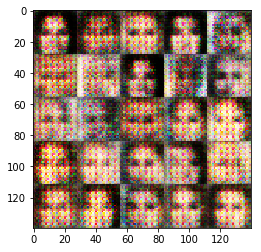

Epoch 1/1... Discriminator Loss: 1.4218... Generator Loss: 0.7885 Sum Loss: 2.2102
Epoch 1/1... Discriminator Loss: 1.4202... Generator Loss: 0.8140 Sum Loss: 2.2341
Epoch 1/1... Discriminator Loss: 1.4101... Generator Loss: 0.6535 Sum Loss: 2.0636
Epoch 1/1... Discriminator Loss: 1.3899... Generator Loss: 0.9403 Sum Loss: 2.3302
Epoch 1/1... Discriminator Loss: 1.4881... Generator Loss: 0.6943 Sum Loss: 2.1824
Epoch 1/1... Discriminator Loss: 1.4681... Generator Loss: 0.6042 Sum Loss: 2.0723
Epoch 1/1... Discriminator Loss: 1.3771... Generator Loss: 0.7023 Sum Loss: 2.0794
Epoch 1/1... Discriminator Loss: 1.3575... Generator Loss: 0.6997 Sum Loss: 2.0571
Epoch 1/1... Discriminator Loss: 1.3705... Generator Loss: 0.6145 Sum Loss: 1.9849
Epoch 1/1... Discriminator Loss: 1.5239... Generator Loss: 0.8337 Sum Loss: 2.3575


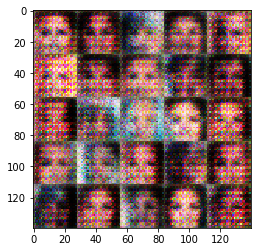

Epoch 1/1... Discriminator Loss: 1.4659... Generator Loss: 0.7148 Sum Loss: 2.1807
Epoch 1/1... Discriminator Loss: 1.4226... Generator Loss: 0.7120 Sum Loss: 2.1345
Epoch 1/1... Discriminator Loss: 1.3892... Generator Loss: 0.7131 Sum Loss: 2.1023
Epoch 1/1... Discriminator Loss: 1.4109... Generator Loss: 0.6945 Sum Loss: 2.1054
Epoch 1/1... Discriminator Loss: 1.4311... Generator Loss: 0.6296 Sum Loss: 2.0607
Epoch 1/1... Discriminator Loss: 1.4417... Generator Loss: 0.7869 Sum Loss: 2.2286
Epoch 1/1... Discriminator Loss: 1.4005... Generator Loss: 0.7191 Sum Loss: 2.1197
Epoch 1/1... Discriminator Loss: 1.4001... Generator Loss: 0.7555 Sum Loss: 2.1556
Epoch 1/1... Discriminator Loss: 1.4942... Generator Loss: 0.8208 Sum Loss: 2.3150
Epoch 1/1... Discriminator Loss: 1.4164... Generator Loss: 0.6060 Sum Loss: 2.0224


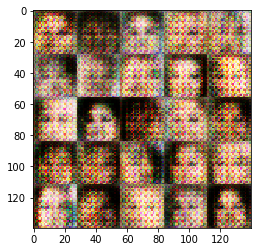

Epoch 1/1... Discriminator Loss: 1.4199... Generator Loss: 0.6796 Sum Loss: 2.0995
Epoch 1/1... Discriminator Loss: 1.4195... Generator Loss: 0.7175 Sum Loss: 2.1370
Epoch 1/1... Discriminator Loss: 1.3914... Generator Loss: 0.7873 Sum Loss: 2.1787
Epoch 1/1... Discriminator Loss: 1.3896... Generator Loss: 0.8758 Sum Loss: 2.2655
Epoch 1/1... Discriminator Loss: 1.4452... Generator Loss: 0.6881 Sum Loss: 2.1333
Epoch 1/1... Discriminator Loss: 1.4180... Generator Loss: 0.6833 Sum Loss: 2.1013
Epoch 1/1... Discriminator Loss: 1.4275... Generator Loss: 0.6815 Sum Loss: 2.1090
Epoch 1/1... Discriminator Loss: 1.4608... Generator Loss: 0.5682 Sum Loss: 2.0290
Epoch 1/1... Discriminator Loss: 1.3856... Generator Loss: 0.7141 Sum Loss: 2.0997
Epoch 1/1... Discriminator Loss: 1.4291... Generator Loss: 0.6697 Sum Loss: 2.0988


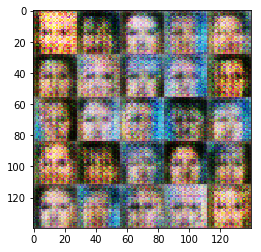

Epoch 1/1... Discriminator Loss: 1.4727... Generator Loss: 0.5070 Sum Loss: 1.9797
Epoch 1/1... Discriminator Loss: 1.3709... Generator Loss: 0.6479 Sum Loss: 2.0189
Epoch 1/1... Discriminator Loss: 1.4153... Generator Loss: 0.7368 Sum Loss: 2.1521
Epoch 1/1... Discriminator Loss: 1.4185... Generator Loss: 0.6652 Sum Loss: 2.0837
Epoch 1/1... Discriminator Loss: 1.4417... Generator Loss: 0.6659 Sum Loss: 2.1075
Epoch 1/1... Discriminator Loss: 1.3923... Generator Loss: 0.6503 Sum Loss: 2.0426
Epoch 1/1... Discriminator Loss: 1.3862... Generator Loss: 0.7067 Sum Loss: 2.0929
Epoch 1/1... Discriminator Loss: 1.4740... Generator Loss: 0.6476 Sum Loss: 2.1216
Epoch 1/1... Discriminator Loss: 1.3767... Generator Loss: 0.7483 Sum Loss: 2.1250
Epoch 1/1... Discriminator Loss: 1.4067... Generator Loss: 0.7654 Sum Loss: 2.1720


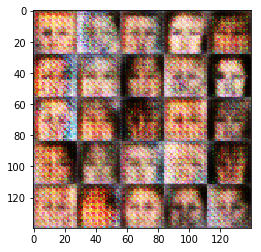

Epoch 1/1... Discriminator Loss: 1.4391... Generator Loss: 0.5887 Sum Loss: 2.0278
Epoch 1/1... Discriminator Loss: 1.4471... Generator Loss: 0.7113 Sum Loss: 2.1584
Epoch 1/1... Discriminator Loss: 1.4303... Generator Loss: 0.7271 Sum Loss: 2.1574
Epoch 1/1... Discriminator Loss: 1.4446... Generator Loss: 0.7818 Sum Loss: 2.2264
Epoch 1/1... Discriminator Loss: 1.3983... Generator Loss: 0.6629 Sum Loss: 2.0612
Epoch 1/1... Discriminator Loss: 1.4793... Generator Loss: 0.7064 Sum Loss: 2.1857
Epoch 1/1... Discriminator Loss: 1.4973... Generator Loss: 0.8122 Sum Loss: 2.3094
Epoch 1/1... Discriminator Loss: 1.3648... Generator Loss: 0.5928 Sum Loss: 1.9576
Epoch 1/1... Discriminator Loss: 1.4321... Generator Loss: 0.6520 Sum Loss: 2.0841
Epoch 1/1... Discriminator Loss: 1.3799... Generator Loss: 0.6241 Sum Loss: 2.0040


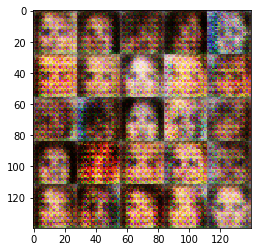

Epoch 1/1... Discriminator Loss: 1.4396... Generator Loss: 0.8131 Sum Loss: 2.2527
Epoch 1/1... Discriminator Loss: 1.4316... Generator Loss: 0.6051 Sum Loss: 2.0368
Epoch 1/1... Discriminator Loss: 1.4315... Generator Loss: 0.6233 Sum Loss: 2.0548
Epoch 1/1... Discriminator Loss: 1.3948... Generator Loss: 0.7140 Sum Loss: 2.1088
Epoch 1/1... Discriminator Loss: 1.4221... Generator Loss: 0.7908 Sum Loss: 2.2129
Epoch 1/1... Discriminator Loss: 1.4441... Generator Loss: 0.6903 Sum Loss: 2.1345
Epoch 1/1... Discriminator Loss: 1.4070... Generator Loss: 0.5494 Sum Loss: 1.9564
Epoch 1/1... Discriminator Loss: 1.3944... Generator Loss: 0.6208 Sum Loss: 2.0153
Epoch 1/1... Discriminator Loss: 1.4760... Generator Loss: 0.7755 Sum Loss: 2.2516
Epoch 1/1... Discriminator Loss: 1.3849... Generator Loss: 0.6704 Sum Loss: 2.0553


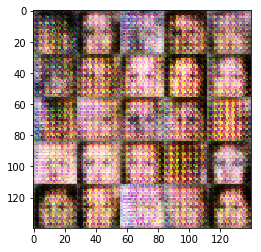

Epoch 1/1... Discriminator Loss: 1.4345... Generator Loss: 0.6896 Sum Loss: 2.1241
Epoch 1/1... Discriminator Loss: 1.3937... Generator Loss: 0.6410 Sum Loss: 2.0347
Epoch 1/1... Discriminator Loss: 1.3532... Generator Loss: 0.7319 Sum Loss: 2.0851
Epoch 1/1... Discriminator Loss: 1.4297... Generator Loss: 0.6149 Sum Loss: 2.0446
Epoch 1/1... Discriminator Loss: 1.5169... Generator Loss: 0.7363 Sum Loss: 2.2532
Epoch 1/1... Discriminator Loss: 1.3868... Generator Loss: 0.6153 Sum Loss: 2.0021
Epoch 1/1... Discriminator Loss: 1.4626... Generator Loss: 0.7656 Sum Loss: 2.2281
Epoch 1/1... Discriminator Loss: 1.4334... Generator Loss: 0.6489 Sum Loss: 2.0823
Epoch 1/1... Discriminator Loss: 1.3976... Generator Loss: 0.6645 Sum Loss: 2.0621
Epoch 1/1... Discriminator Loss: 1.4008... Generator Loss: 0.7733 Sum Loss: 2.1741


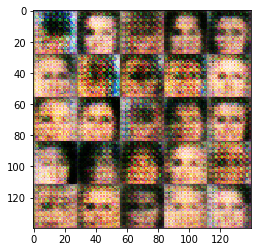

Epoch 1/1... Discriminator Loss: 1.4609... Generator Loss: 0.6345 Sum Loss: 2.0953
Epoch 1/1... Discriminator Loss: 1.3955... Generator Loss: 0.6312 Sum Loss: 2.0267
Epoch 1/1... Discriminator Loss: 1.3882... Generator Loss: 0.7560 Sum Loss: 2.1441
Epoch 1/1... Discriminator Loss: 1.3968... Generator Loss: 0.6912 Sum Loss: 2.0880
Epoch 1/1... Discriminator Loss: 1.3893... Generator Loss: 0.6768 Sum Loss: 2.0660
Epoch 1/1... Discriminator Loss: 1.4153... Generator Loss: 0.6559 Sum Loss: 2.0712
Epoch 1/1... Discriminator Loss: 1.3758... Generator Loss: 0.7986 Sum Loss: 2.1744
Epoch 1/1... Discriminator Loss: 1.4154... Generator Loss: 0.7016 Sum Loss: 2.1170
Epoch 1/1... Discriminator Loss: 1.3389... Generator Loss: 0.6667 Sum Loss: 2.0056
Epoch 1/1... Discriminator Loss: 1.4290... Generator Loss: 0.6108 Sum Loss: 2.0399


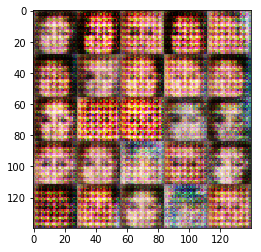

Epoch 1/1... Discriminator Loss: 1.4126... Generator Loss: 0.6381 Sum Loss: 2.0508
Epoch 1/1... Discriminator Loss: 1.5073... Generator Loss: 0.5839 Sum Loss: 2.0912
Epoch 1/1... Discriminator Loss: 1.4821... Generator Loss: 0.5369 Sum Loss: 2.0190
Epoch 1/1... Discriminator Loss: 1.3982... Generator Loss: 0.6570 Sum Loss: 2.0552
Epoch 1/1... Discriminator Loss: 1.4210... Generator Loss: 0.5835 Sum Loss: 2.0044
Epoch 1/1... Discriminator Loss: 1.4191... Generator Loss: 0.7793 Sum Loss: 2.1984
Epoch 1/1... Discriminator Loss: 1.3911... Generator Loss: 0.7198 Sum Loss: 2.1109
Epoch 1/1... Discriminator Loss: 1.4660... Generator Loss: 0.7796 Sum Loss: 2.2456
Epoch 1/1... Discriminator Loss: 1.4546... Generator Loss: 0.7027 Sum Loss: 2.1573
Epoch 1/1... Discriminator Loss: 1.3625... Generator Loss: 0.7283 Sum Loss: 2.0909


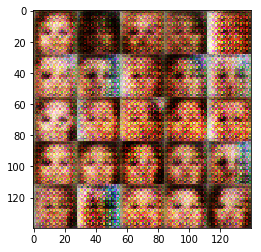

Epoch 1/1... Discriminator Loss: 1.3933... Generator Loss: 0.6430 Sum Loss: 2.0364
Epoch 1/1... Discriminator Loss: 1.4188... Generator Loss: 0.7709 Sum Loss: 2.1897
Epoch 1/1... Discriminator Loss: 1.4698... Generator Loss: 0.5865 Sum Loss: 2.0563
Epoch 1/1... Discriminator Loss: 1.3964... Generator Loss: 0.6323 Sum Loss: 2.0287
Epoch 1/1... Discriminator Loss: 1.5547... Generator Loss: 0.8313 Sum Loss: 2.3860
Epoch 1/1... Discriminator Loss: 1.4142... Generator Loss: 0.6544 Sum Loss: 2.0685


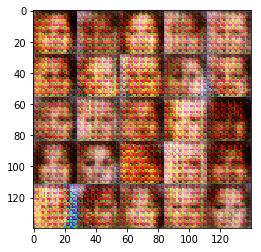

In [47]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.